In [1]:
import scipy
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [2]:
dataset_train = loadmat("train_spanish_2022_python.mat")
dataset_validation = loadmat("validation_spanish_2022_python.mat")

In [3]:
dataset_train.keys()

dict_keys(['__header__', '__version__', '__globals__', 'features_train', 'labels_train_int'])

In [4]:
dataset_train["labels_train_int"].shape

(11554, 1)

In [5]:
Xtrain = dataset_train["features_train"]
Ytrain = dataset_train["labels_train_int"].flatten()

In [6]:
dataset_validation.keys()

dict_keys(['__header__', '__version__', '__globals__', 'features_validation', 'labels_validation_int'])

In [7]:
Xval = dataset_validation["features_validation"]
Yval = dataset_validation["labels_validation_int"].flatten()

# Normalizacion

In [8]:
m = Xtrain.mean(axis=0, keepdims=True)
s = Xtrain.std(axis=0, keepdims=True)

Xtrain_norm = (Xtrain - m) / s
Xval_norm = (Xval - m) / s

In [9]:
m.shape

(1, 85)

# Create dataset

In [10]:
import torch
from torch.utils.data import TensorDataset, DataLoader


# Convert lists to tensors
Xtrain_tensor = torch.tensor(Xtrain_norm, dtype=torch.float32)
Ytrain_tensor = torch.tensor(Ytrain, dtype=torch.long)

Xval_tensor = torch.tensor(Xval_norm, dtype=torch.float32)
Yval_tensor = torch.tensor(Yval, dtype=torch.long)

# Create TensorDataset
train_dataset = TensorDataset(Xtrain_tensor, Ytrain_tensor)
val_dataset = TensorDataset(Xval_tensor, Yval_tensor)
# Create DataLoader

# Primera red

In [11]:
import torch
from torch import nn

In [12]:
class Red(nn.Sequential):
    def __init__(
        self,
        input_dim=85,
        hidden_dim=[
            4,
        ],
        out_dim=10,
        dropout=0.0,
    ):
        assert len(hidden_dim) > 0, "at least one hidden layer"
        layers = []
        # first layer
        layers.append(nn.Linear(input_dim, hidden_dim[0]))
        layers.append(nn.BatchNorm1d(hidden_dim[0]))
        if dropout > 0.0:
            layers.append(nn.Dropout(dropout))
        layers.append(nn.ReLU(inplace=True))

        if len(hidden_dim) > 1:
            for k in range(1, len(hidden_dim)):
                layers.append(nn.Linear(hidden_dim[k - 1], hidden_dim[k]))
                layers.append(nn.BatchNorm1d(hidden_dim[k]))
                layers.append(nn.Dropout(dropout))
                layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(hidden_dim[-1], out_dim))
        super().__init__(*layers)

# Training loop

In [13]:
def train_epoch(network, loss_fn, dataloader, optimizer, device="cpu"):
    # Set the network to train mode
    network.to(device)
    network.train()

    # Initialize variables to keep track of loss and number of batches
    epoch_loss = 0.0
    num_batches = 0
    epoch_correct = 0.0
    num_samples = 0

    # Iterate over the data loader
    for batch_inputs, batch_targets in dataloader:
        # Move data to the appropriate device (e.g., GPU)
        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        batch_outputs = network(batch_inputs)

        # Compute the loss
        loss = loss_fn(batch_outputs, batch_targets)

        # Backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()

        # Accumulate the loss
        epoch_loss += loss.item()
        num_batches += 1

        # Calculate the number of correct predictions in the batch
        _, predicted = torch.max(batch_outputs, 1)
        epoch_correct += (predicted == batch_targets).sum().item()
        num_samples += batch_targets.size(0)

    # Calculate the average loss for the epoch
    average_loss = epoch_loss / num_batches

    # Calculate the accuracy for the epoch
    accuracy = epoch_correct / num_samples

    return average_loss, accuracy

In [14]:
def validate_epoch(network, loss_fn, dataloader, device="cpu"):
    # Set the network to evaluation mode
    network.to(device)
    network.eval()

    # Initialize variables to keep track of loss and number of batches
    epoch_loss = 0.0
    num_batches = 0
    epoch_correct = 0.0
    num_samples = 0

    # Turn off gradients
    with torch.no_grad():
        # Iterate over the data loader
        for batch_inputs, batch_targets in dataloader:
            # Move data to the appropriate device (e.g., GPU)
            batch_inputs = batch_inputs.to(device)
            batch_targets = batch_targets.to(device)

            # Forward pass
            batch_outputs = network(batch_inputs)

            # Compute the loss
            loss = loss_fn(batch_outputs, batch_targets)

            # Accumulate the loss
            epoch_loss += loss.item()
            num_batches += 1

            # Calculate the number of correct predictions in the batch
            _, predicted = torch.max(batch_outputs, 1)
            epoch_correct += (predicted == batch_targets).sum().item()
            num_samples += batch_targets.size(0)

    # Calculate the average loss for the epoch
    average_loss = epoch_loss / num_batches

    # Calculate the accuracy for the epoch
    accuracy = epoch_correct / num_samples

    return average_loss, accuracy

In [15]:
from tqdm import tqdm


def train(
    network,
    loss_fn,
    train_dataloader,
    val_dataloader,
    optimizer,
    num_epochs,
    device="cpu",
):
    train_losses = []
    val_losses = []
    val_acc = []
    train_acc = []

    best_val_acc = 0.0
    best_epoch = -1

    # Initialize tqdm for progress tracking
    progress_bar = tqdm(range(num_epochs), desc="Training Progress")

    for epoch in progress_bar:
        # Training phase
        train_loss, train_accuracy = train_epoch(
            network, loss_fn, train_dataloader, optimizer, device=device
        )
        train_losses.append(train_loss)
        train_acc.append(train_accuracy)
        # Validation phase
        val_loss, val_accuracy = validate_epoch(
            network, loss_fn, val_dataloader, device=device
        )
        val_losses.append(val_loss)
        val_acc.append(val_accuracy)

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_epoch = epoch
            print(f"Best val acc {best_val_acc:.3f} at epoch {epoch}")
        # Print the loss for each epoch
        # print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f},Val Loss: {val_loss:.4f} Val Acc: {accuracy:.4f}')

        # Update tqdm progress bar
        progress_bar.set_postfix(
            {
                "Train Loss": train_loss,
                "Val Loss": val_loss,
                "Train Acc": train_accuracy,
                "Val Acc": val_accuracy,
            }
        )
    return train_losses, val_losses, train_acc, val_acc

Training Progress:   2%|▏         | 2/100 [00:00<00:14,  6.82it/s, Train Loss=1.93, Val Loss=1.61, Train Acc=0.266, Val Acc=0.331]

Best val acc 0.320 at epoch 0
Best val acc 0.331 at epoch 1


Training Progress:   4%|▍         | 4/100 [00:00<00:15,  6.22it/s, Train Loss=1.62, Val Loss=1.35, Train Acc=0.356, Val Acc=0.437]

Best val acc 0.432 at epoch 2
Best val acc 0.437 at epoch 3


Training Progress:   6%|▌         | 6/100 [00:01<00:18,  5.20it/s, Train Loss=1.6, Val Loss=1.32, Train Acc=0.38, Val Acc=0.492]  

Best val acc 0.458 at epoch 4
Best val acc 0.492 at epoch 5


Training Progress:   7%|▋         | 7/100 [00:01<00:17,  5.20it/s, Train Loss=1.56, Val Loss=1.14, Train Acc=0.401, Val Acc=0.618]

Best val acc 0.618 at epoch 6


Training Progress:  10%|█         | 10/100 [00:01<00:18,  4.74it/s, Train Loss=1.37, Val Loss=1.06, Train Acc=0.501, Val Acc=0.609]

Best val acc 0.648 at epoch 8


Training Progress:  13%|█▎        | 13/100 [00:02<00:17,  4.96it/s, Train Loss=1.25, Val Loss=0.903, Train Acc=0.558, Val Acc=0.721]

Best val acc 0.681 at epoch 11
Best val acc 0.721 at epoch 12


Training Progress:  15%|█▌        | 15/100 [00:02<00:16,  5.09it/s, Train Loss=1.16, Val Loss=0.845, Train Acc=0.598, Val Acc=0.753]

Best val acc 0.746 at epoch 13
Best val acc 0.753 at epoch 14


Training Progress:  19%|█▉        | 19/100 [00:03<00:16,  4.97it/s, Train Loss=1.14, Val Loss=0.823, Train Acc=0.613, Val Acc=0.746]

Best val acc 0.783 at epoch 17


Training Progress:  21%|██        | 21/100 [00:04<00:16,  4.77it/s, Train Loss=1.16, Val Loss=0.714, Train Acc=0.603, Val Acc=0.804]

Best val acc 0.804 at epoch 20


Training Progress:  34%|███▍      | 34/100 [00:07<00:15,  4.37it/s, Train Loss=1.1, Val Loss=0.766, Train Acc=0.631, Val Acc=0.807] 

Best val acc 0.807 at epoch 33


Training Progress:  55%|█████▌    | 55/100 [00:11<00:10,  4.27it/s, Train Loss=1.01, Val Loss=0.882, Train Acc=0.662, Val Acc=0.798] 

Best val acc 0.814 at epoch 53


Training Progress:  59%|█████▉    | 59/100 [00:12<00:08,  4.75it/s, Train Loss=0.995, Val Loss=0.843, Train Acc=0.662, Val Acc=0.809]

Best val acc 0.817 at epoch 57


Training Progress:  69%|██████▉   | 69/100 [00:14<00:06,  4.82it/s, Train Loss=1, Val Loss=0.94, Train Acc=0.67, Val Acc=0.759]      

Best val acc 0.818 at epoch 67


Training Progress:  75%|███████▌  | 75/100 [00:15<00:04,  5.11it/s, Train Loss=0.965, Val Loss=0.829, Train Acc=0.676, Val Acc=0.821]

Best val acc 0.837 at epoch 73


Training Progress:  85%|████████▌ | 85/100 [00:17<00:03,  4.98it/s, Train Loss=0.981, Val Loss=0.943, Train Acc=0.68, Val Acc=0.746] 

Best val acc 0.839 at epoch 83


Training Progress: 100%|██████████| 100/100 [00:21<00:00,  4.67it/s, Train Loss=0.948, Val Loss=0.812, Train Acc=0.689, Val Acc=0.782]


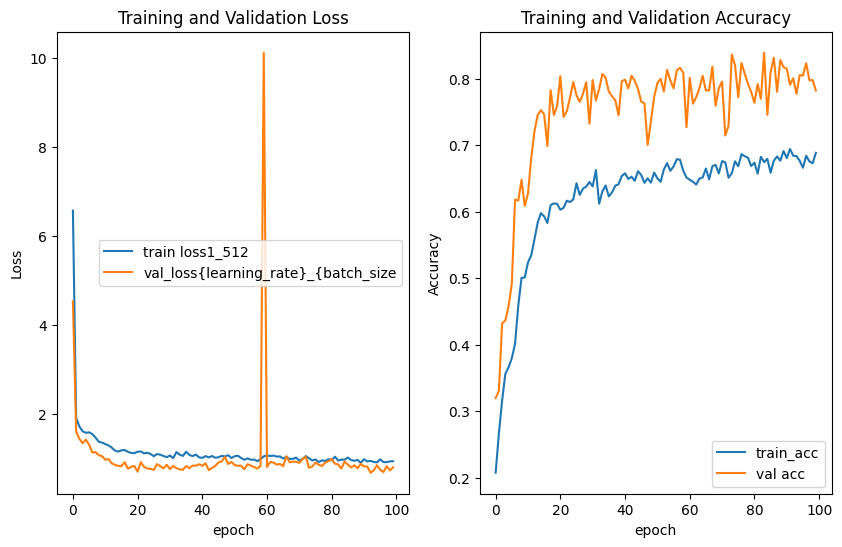

In [16]:
import torch.optim as optim

# Assuming you have already defined your neural network model and loss function
# network = YourNeuralNetwork()
# loss_fn = YourLossFunction()
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

for learning_rate in range(1, 2):
    for batch_size in range(1, 2, 1):
        # Define learning rate
        learning_rate = learning_rate
        batch_size = 512 * batch_size

        # Define network
        red1 = Red(hidden_dim=[128, 128], dropout=0.25)

        # Create Adam optimizer
        # optimizer = optim.SGD(red1.parameters(), lr=learning_rate, momentum =0.9)
        optimizer = optim.Adam(red1.parameters(), lr=learning_rate)
        loss_fn = nn.CrossEntropyLoss()

        num_epochs = 100
        train_dataloader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True
        )
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        train_losses, val_losses, train_acc, val_acc = train(
            red1,
            loss_fn,
            train_dataloader,
            val_dataloader,
            optimizer,
            num_epochs,
            device="cpu",
        )

        # Graphs
        ax0 = axes[0]
        ax0.plot(train_losses, label=f"train loss{learning_rate}_{batch_size}")
        ax0.plot(val_losses, label="val_loss{learning_rate}_{batch_size")
        ax0.set_xlabel("epoch")
        ax0.set_ylabel("Loss")
        ax0.set_title("Training and Validation Loss")
        ax0.legend()

        ax1 = axes[1]
        ax1.plot(train_acc, label="train_acc")
        ax1.plot(val_acc, label="val acc")
        ax1.set_xlabel("epoch")
        ax1.set_ylabel("Accuracy")
        ax1.set_title("Training and Validation Accuracy")
        ax1.legend()

plt.show()